# Alpha diversite : richesse de genres assignés

Dans cette partie, nous déterminons la richesse de genres assignés. Il s'agit de déterminer le nombre total de genres distincts qui ont été assignés. Ce nombre peut différer en fonction de la base de référence. 
Ensuite, nous essayons de déterminer s'il existe une différence de richesse significative en fonction de la température et, le cas échéant, si cette différence est significative quelque soit la base de référence utilisée pour l'assignation taxonomique, c'est-à-dire si chacune des bases réalise des assignations permettant de mettre en lumière la différence de composition en fonction de la température.

## Préparation de l'environnement et des données
### Installation des packages nécessaires

In [18]:
# Installation de packages nécessaires

# chargement de la librairie devtools, permettant notamment d'installer des packages depuis depuis GitHub 
library(devtools)
# installation du package pairwiseAdonis
install_github("pmartinezarbizu/pairwiseAdonis/pairwiseAdonis")

Loading required package: usethis


Attaching package: ‘devtools’


The following object is masked from ‘package:permute’:

    check






── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/slurm_mthemezeleroy_37008213.tmp/RtmpQnnW6c/remotes1aabdb7848c5d/pmartinezarbizu-pairwiseAdonis-cb190f7/pairwiseAdonis/DESCRIPTION’ ... OK
* preparing ‘pairwiseAdonis’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘pairwiseAdonis_0.4.1.tar.gz’



Installing package into ‘/shared/home/mthemezeleroy/R/x86_64-conda-linux-gnu-library/4.4’
(as ‘lib’ is unspecified)



### Chargement des libraires nécessaires 

In [1]:
library(tidyverse) # collection de packages pour la manipulation de données
library(vegan) # librairie nécessaire pour la fonction adonis2
library(pairwiseAdonis) # librairie nécessaire pour la fonction pairwiseAdonis

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: permute

Loading required package: lattice

This is vegan 2.6-8

Loading required package: cluster



### Importation des données

Les données utilisées dans cette partie correspondent aux données se trouvant dans le tableau construit dans le jupyter notebook [2.Preparation data.ipynb](/2.Preparation data.ipynb). 

In [2]:
# Importation du fichier csv
df_pm4 <- tibble(read.csv("data/output/data_final_pm4.csv", sep = ";"))

### Détermination de la richesse de genre assignés
Nous allons créer un dataframe avec une nouvelle colonne "S_genus" qui va contenir le nombre total de genres uniques assignés pour chaque individu. En choisissant de comptabiliser les genres uniques, ce nombre sera différent de la frequence d'assignation au genre. Il comptabilise qu'une seul fois un genre, même si celui-ci a été assigné à plusieurs ASVs. 

In [3]:
# Estimation de la richesse de genres assignés pour chaque température, en fonction de la base
df_genus <- df_pm4 |> 
    # Regrouper par echantillon, température et base de référence pour l'assignation
    group_by(sample.id, base_ref, temperature) |> 
    # Determiner le nombre de genre distincts, assignés (différents de NA) pour chaque individu en fonction de la temperature et de la base de référence pour l'assignation
    summarise(S_genus = n_distinct(Genus[!is.na(Genus)])) |> 
    ungroup()|> 
    # Selectionner les colonnes sample.id, temperature, base_ref, S_genus
    select(sample.id, temperature, base_ref, S_genus)

`summarise()` has grouped output by 'sample.id', 'base_ref'. You can override
using the `.groups` argument.


## Exploration des données
Dans cette partie, nous allons explorer la relation entre richesse de genre et température en fonction de la base de référence utilisée pour l'assignation taxonomique afin de déterminer s'il existe des différence de diversité alpha en fonction de la température.

`summarise()` has grouped output by 'base_ref'. You can override using the
`.groups` argument.


ERROR: Error: object 'pmx_genus_plot' not found


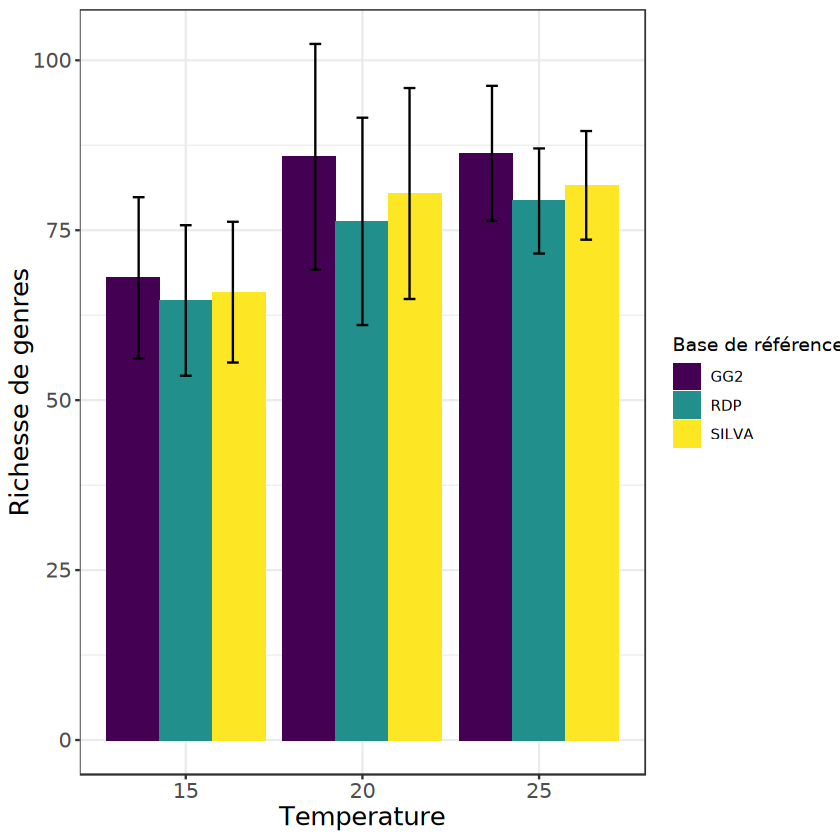

In [4]:
# Représentation graphique 

# Préparation du dataframe qui sera utilisé pour le graphique
df_genus_plot <- df_genus |> 
    # Regrouper par température et base de référence pour obtenir 
    group_by(base_ref, temperature) |> 
    summarise(
        # Calcul de la richesse moyenne pour chaque couple base*temp
        S_genus_mean = mean(S_genus),
        # Calcul de la deviation standard pour chaque couple base*temp
        S_genus_sd = sd(S_genus),
        # Calcul de l'erreur standard pour chaque couple base*temp
        S_genus_se = S_genus_sd/sqrt(n()),
        # Calcul du nombre d'individus par couple base*temp
        n_sample=n()) # Permet de vérifier que le regroupement par température est bien fait

# Réalisation du graphique 
pmv_genus_plot <- ggplot(df_genus_plot, aes(x = factor(temperature), y = S_genus_mean, fill = base_ref, coulour = base_ref)) +
    geom_bar(stat = "identity", position = "dodge") + 
    geom_errorbar(aes(ymin = S_genus_mean - S_genus_se, ymax = S_genus_mean + S_genus_se), position = position_dodge(width = 0.8), width = 0.2, linewidth = 0.5) +
    labs(x = "Temperature", y = "Richesse de genres", fill = "Base de référence") +
    guides(colour = "none") + 
## Choix de la charte graphique
    scale_fill_viridis_d() + # choix des couleurs de remplissage des bar
    scale_colour_viridis_d() + # choix des couleurs de contour des bar
    # Ajout d'un thème noir et blanc
    theme_bw() + 
    # Choix des tailles de texte pour les axes et le titre des axes
    theme(axis.title = element_text(size = 15),
        axis.text = element_text(size = 12))

# Affichage du graphique obtenu
pmv_genus_plot

# Sauvegarde du graphqiue obtenu dans le dossier "figures"
ggsave("data/output/figures/S_genus_pmv.png", pmx_genus_plot, width = 6, height = 5)

Le graphique ci-dessus représente la richesse de genres (uniques) assignés par couple _Temperature * Base de référence_. Les barres colorées représentent la moyenne de richesse de genre et la barre d'erreur repéresent l'erreur standard. 

Nous voyons que : 
- La richesse de genre semble augmenter pour une élévation de température entre 15°C et 20°C; elle semble rester constante de 20°C à 25°C pour GG2 et légèrement augmenter pour SILVA et RDP. 
- Pour une même température, en prenant en compte la variabilité avec l'erreur standard, le richesse de genres ne présente pas de différences significatives entre bases de références.

Il semblerait donc qu'il y ait une plus grande diversité du microbiome à des températures plus élevées. Cependant, cette analyse ne prend en compte que les ASVs qui ont obtenus une assignation taxonomique. Ce résultat peut donc être biasé par le fait que les bases de références contiendraient plus de références taxonomiques pour des procaryotes ayant des optimums et des seuils de tolérance de température plus élevées. Cela pourrait être le cas si nous considérons que les espèces tropicales ont reçu plus d'intérêt d'étude que des espèces des milieux tempérés.  

Contrairement à la fréquence d'assignation, la richesse en genres semble augmenter avec la température. Ceci peut paraître contradictoire mais pourrait s'expliquer par le fait que pour la fréquence d'assignation, un même genre peut être attribué pour plusieurs ASVs. En terme de proportion, cela voudrait dire que pour un plus faible nombre d'assignations totales à 25°C, les assignations étaient moins redondantes qu'à 15°C. 

## Analyse statistique
Nous allons déterminer si la différence observée est statistiquement significative. Des analyses préalabbles montrent que les conditions de normalité ne sont pas respectées, ainsi nous réalisons une PERMANOVA qui ne fait aucune hypothèse sur la normalité ou l'homogénéité des variances. Les analyses de normalité sont disponibles en fin de script. 

### PERMANOVA
Nous allons réaliser une analyse de variance multivariée permutationnelle (PERMANOVA) en utilisant la matrice de dissimilarité de Bray-Curtis pour tester les différences significatives dans la richesse de genres assignés à travers la température,  la base de référence utilisée pour l'assignation taxonomique, et l'intéraction entre les deux. 

#### Préparation des données pour la PERMANOVA

In [5]:
# Créer un sous-tableau contenant QUE la richesse de genres assignés pour calculer les matrice de dissimilarité
mx_pmv_g <- df_genus  |> 
  select(-c(sample.id,temperature,base_ref))  # retirer les colonnes correspondant aux metadonnées

# Créer un sous-tableau contenant que les metadonnées
env_pmv_g <- df_genus |> 
  select(sample.id,temperature,base_ref) |> # conserver uniquement les colonnes correspondant aux metadonnées
  mutate(temperature = as.factor(temperature), base_ref= as.factor(base_ref)) # transformer les variables temperature et base_ref en facteurs

#### PERMANOVA : _Richesse de genre ~ Température * Base de référence_

In [6]:
set.seed(123) # Initialisation d'une graine aléatoire pour la reproductibilité des permutations

# Determiner la matrice de distance entre échantillons avec la méthode de Bray-Curtis
bray_dist_g <- vegdist(mx_pmv_g, method = "bray")

# Réalisation de la PERMANOVA
pmv_g_t <- adonis2(bray_dist_g ~ temperature * base_ref, data = env_pmv_g, by = "terms")
pmv_g_t

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
temperature,2,0.25860284,0.069719087,2.94027024,0.046
base_ref,2,0.01654111,0.004459468,0.18806959,0.912
temperature:base_ref,4,0.00393703,0.001061420,0.02238168,1.000
Residual,78,3.43013060,0.924760026,NA,NA
Total,86,3.70921158,1.000000000,NA,NA


La PERMANOVA a révélé que : 
- la base de référence (F = 0.19, R² = 0.004, p = 0.912) n'a pas d'effet significatif. L'absence d'influence de la base de donnée sur la richesse de genre était attendu car d'un point de vue écologique la base de référence utilisée ne devrait pas avoir une influence sur la diversité. 
- l'interaction entre la température et base de référence (F = 0.02, R² = 0.001, p = 1.00) n'est pas significative. L'absence d'effet de l'intéraction entre température et base de donnée montre que pour une même température peu importe la base de référence utilisée, il n'y aura pas de différence de diversité. 
- il existe des **différences significatives dans la richesse de genre en fonction de la température** (F = 2.94, R² = 0.069, p = 0.046). 

Ces trois points sont réconfortants d'un point de vue méthodologique : il y a un effet de la température sur la diverité de genre et celui-ci peu être démontré peu importe la base de référence utilisée pour l'assignation taxonomique.

Il est à noter que le modèle complet explique uniquement 8% de la variation totale (R² = 0.08). Ainsi, d'autres facteurs seraient à prendre en compte pour expliquer la diversité. 

#### Post-hoc
Nous allons déterminer quelles températures présentent des différences significatives de richesse de genre.

In [7]:
# Tests post hoc PERMANOVA

# Comparaison 2 à 2 des richesses en fonction de la température 
pairwise.adonis2(bray_dist_g ~ temperature, data = env_pmv_g)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,1,0.08058701,0.02849984,1.613475,0.207
Residual,55,2.74704311,0.97150016,NA,NA
Total,56,2.82763012,1.00000000,NA,NA
,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model,1,0.2115202,0.1232591,7.732328,0.007
Residual,55,1.5045415,0.8767409,NA,NA
Total,56,1.7160617,1.0000000,NA,NA
,Df,SumOfSqs,R2,F,Pr(>F)


Il y a une différence significative de richesse entre les températures **15°C et 25°C** (p = 0.007).

#### Analyse de la dispersion 
Nous allons déterminer si les différences entre températures sont due à une différence de composition ou de dispersion autour d'un centroid. 

In [10]:
# Analyse de la dispersion 
disp_temp <- betadisper(bray_dist_g, env_pmv_g$temperature)

# Déterminer s'il y a des différences significatives de dispersion ou homogénéité
anova(disp_temp) 

# Déterminer entre quelles températures il y a des différences significatives de dispersion
TukeyHSD(disp_temp)

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Groups,2,0.1290718,0.06453590,3.256973,0.04341894
Residuals,84,1.6644339,0.01981469,NA,NA


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
              diff         lwr         upr     p adj
20-15  0.076711360 -0.01238323 0.165805945 0.1057654
25-15 -0.007711676 -0.09680626 0.081382909 0.9767686
25-20 -0.084423036 -0.17114134 0.002295265 0.0580897


L'analyse de la dispersion montre des différences significatives de dispersion (p=0.0434). Celles-ci est présente pour les températures 20°C et 25°C. Ainsi, comme il y a homogénéité de dispersion **entre les températures 15°C et 25°C, la différence de diversité trouvée par le PERMANOVA est bien une différence de composition.**

### _Analyse de la normalité_
Nous réalisons des tests de shapiro pour déterminer si la richesse de genres assignés suit une distribution normale en fonction des 9 couples de condition temperature * base de référence. 

In [ ]:
# Creation d'un dataframe contenant pour chaque couple de condition, la statistique de test 
# et la valeur p du test de shapiro  

norm_g <- df_genus |> 
    group_by(base_ref, temperature) |>
    summarise(p_shap = shapiro.test(S_genus)$p.value,
              stat_shap = shapiro.test(S_genus)$statistic)

# Creation d'une variable contenant le nombre de couple de conditions pour lesquelles la distribution de la 
# richesse de genre assignés S_genus ne suit pas une loi normale. Pour un test de Shapiro, l'hypothèse H0 
# est que la distribution étudiée est égale a une distribution normale. Ainsi, lorsque le risque alpha = 0.05 
# la distribution n'est pas normale lorsqu'on rejette H0 (p < 0.05)

not_normal <- length(unique(norm_g$p_shap) < 0.05)
not_normal # Si "not_normal" est différent de 0, alors les conditions de normalité ne sont pas respectées pour 
# au moins un des couples de conditions.
# Ici, not_normal = 9, ainsi la normalité n'est respectée pour aucun des couples. 
# Nous ne respectons pas les conditions nécessaires pour réaliser une ANOVA. 